In [1]:
import pandas as pd
import numpy as np
import scipy as sp
import seaborn as sn
import folium
import math
import json
from branca.colormap import LinearColormap
from branca.element import MacroElement
from jinja2 import Template
import matplotlib.pyplot as plt

**Query on Google Big Query to create the mentions.csv dataframe :**

SELECT ActionGeo_CountryCode AS LocEvent, EventRootCode, COUNT(*) as NumberOfMentions 

FROM (

      SELECT GLOBALEVENTID AS GLOBALEVENTID_mentions
      
      FROM `gdelt-bq.gdeltv2.eventmentions` 
      
      WHERE MentionType =1      
      
      ) 
      
INNER JOIN `gdelt-bq.gdeltv2.events` ON `gdelt-bq.gdeltv2.events`.GLOBALEVENTID = GLOBALEVENTID_mentions 

GROUP BY ActionGeo_CountryCode, EventRootCode

**Loading the csv files into the notebook :**

In [2]:
mentions = pd.read_csv('../Data_sinan/mentions.csv', dtype={'EventRootCode': np.str})

#Fips_codes will be useful further to get the country names from their respective fips codes
fips_codes = pd.read_csv('../Data/fipscountries.csv')
fips_codes = fips_codes[['fips','country']]

#From happiness_df, we will get the happiness scores for 156 countries
happiness_df = pd.read_excel('../Data_sinan/WHR2018Chapter2OnlineData.xls', sheet_name='Figure2.2')
happiness_df = happiness_df[['Country','Happiness score']]
happiness_df.rename(index=str, columns={"Country": "country"}, inplace=True)

#Reading the world happiness report 2018
politics_df = pd.read_excel('../Data_sinan/WHR2018Chapter2OnlineData.xls')

#Creating the confidence_df from the year, country and Confidence in national government features of the politics_df
confidence_df = politics_df[['year', 'country', 'Confidence in national government']]
confidence_df = confidence_df.dropna()
#The dataframe contains information for multiple years for each country, thus we just take in consideration the most recent information
confidence_df = confidence_df.sort_values('year', ascending=False) \
                             .groupby("country") \
                             .first()

#Creating the corruption_df from the year, country and Perceptions of corruption features of the politics_df
corruption_df = politics_df[['year', 'country', 'Perceptions of corruption']]
corruption_df = corruption_df.dropna()
#The dataframe contains information for multiple years for each country, thus we just take in consideration the most recent information
corruption_df = corruption_df.sort_values('year', ascending=False)\
                             .groupby("country").first()

#To construct, further, relations between the media and the political indicators, merging the corruption and confidence in gouvernment on each country
politics_df = corruption_df.merge(confidence_df, on='country', how='inner')
politics_df.rename(index=str, columns={"year_x": "year_corruption", "year_y": "year_confidence"}, inplace=True)

#Loading the The Economist's Democracy Index by Country(2017) 
democracy_index_df =  pd.read_csv('../Data_sinan/democracy_index.csv')
democracy_index_df =  democracy_index_df[['Country', 'Score']]
democracy_index_df.rename(index=str, columns={"Country": "country", "Score": "Democratic Quality"}, inplace=True)


#country_info_df = pd.read_csv('../Data_sinan/countryinfo.csv')
#world_borders = json.load(open('../Data/world_borders.topojson.json'))

In [3]:
#gdeltv2countries = pd.DataFrame(data=mentions['LocEvent'].unique(), columns=['fips'])
#gdeltv2countries = fips_codes.merge(gdeltv2countries, \
#                                    on='fips',
#                                     how='inner' \
#                                    ) 
#gdeltv2countries.shape

In [4]:
#countries = gdeltv2countries.merge(happiness_df, on='country')
#gdeltv2countries[(~gdeltv2countries.country.isin(countries.country))].shape

In [5]:
politics_df.head()

,year_corruption,Perceptions of corruption,year_confidence,Confidence in national government
country,,,,
Afghanistan,2017,0.954393,2017,0.261179
Albania,2017,0.876135,2017,0.457738
Angola,2014,0.834076,2014,0.572346
Argentina,2017,0.841052,2017,0.305430
Armenia,2017,0.864683,2017,0.246901


Let's observe our mentions dataframe coming from GDELTV2 and see if there are unwanted values for EventRootCode feature :

In [6]:
mentions['EventRootCode'].value_counts()

04    263
01    260
02    258
07    258
09    257
03    257
12    256
06    256
05    256
19    254
08    254
17    254
11    253
18    252
13    252
16    251
10    250
14    249
15    246
20    220
--     23
X       1
Name: EventRootCode, dtype: int64

"--" and "X" codes are not defined, thus dropping the rows corresponding to these codes:

In [7]:
mentions = (mentions[(mentions["EventRootCode"]!='X') & (mentions["EventRootCode"]!='--')])

**Creating the dataframe containing the information about the proportion of the number of protest news over the total number of news for each country :**

In [8]:
#Summing the number of mentions by country
mentions_by_country = mentions.groupby(['LocEvent'], as_index=False).sum()[['LocEvent','NumberOfMentions']]

#Summing the number of protest mentions by country
df = mentions.groupby(['LocEvent', 'EventRootCode'], as_index=False).sum()
protest_mentions_by_country = df[df['EventRootCode']=='14'].drop(columns=['EventRootCode']) \
                                                           .rename(index=str, \
                                                                   columns={"NumberOfMentions": "Number of protest mentions"},\
                                                                  )

#Creating the relative_mentions dataframe by merging the 2 dataframes created above on country FIPS Code
#and adding the column obtained by dividing the number or protest news by the number of news 
#for each country
relative_mentions = protest_mentions_by_country.merge(mentions_by_country, on='LocEvent', how='inner')
relative_mentions['Relative number of protest'] = relative_mentions['Number of protest mentions']/relative_mentions['NumberOfMentions']



In [9]:
relative_mentions.head()

,LocEvent,Number of protest mentions,NumberOfMentions,Relative number of protest
0,AA,203,47695,0.004256
1,AC,216,98264,0.002198
2,AE,11925,2934690,0.004063
3,AF,56085,9718130,0.005771
4,AG,15104,1456706,0.010369


**Adding the country names for each corresponding FIPS Code by merging with the dataframe containing the country names for FIPS Codes :**


In [10]:
relative_mentions = fips_codes.merge(relative_mentions, \
                                     left_on='fips', \
                                     right_on='LocEvent', \
                                     how='inner' \
                                    ) \
                              .drop(columns=['LocEvent'])

**Finally putting all the information together for each country :**

In [11]:
#population = country_info_df[['fips', 'population']]
#relative_mentions = relative_mentions.merge(population, on='fips', how='inner')
relative_mentions = relative_mentions.merge(happiness_df, on='country', how='inner')
relative_mentions = relative_mentions.merge(politics_df, on='country', how='inner')
relative_mentions = relative_mentions.merge(democracy_index_df, on='country', how='inner')


In [12]:
relative_mentions.head()

,fips,country,Number of protest mentions,NumberOfMentions,Relative number of protest,Happiness score,year_corruption,Perceptions of corruption,year_confidence,Confidence in national government,Democratic Quality
0,AF,Afghanistan,56085,9718130,0.005771,3.6315,2017,0.954393,2017,0.261179,2.55
1,AL,Albania,62138,3367533,0.018452,4.5860,2017,0.876135,2017,0.457738,5.98
2,AM,Armenia,42372,2679371,0.015814,4.3206,2017,0.864683,2017,0.246901,4.11
3,AO,Angola,10950,1671962,0.006549,3.7948,2014,0.834076,2014,0.572346,3.62
4,AR,Argentina,49026,5527104,0.008870,6.3880,2017,0.841052,2017,0.305430,6.96


**Analysing the relation between the relative number of protest news and the indicators :**

In [13]:
corr = relative_mentions[['Relative number of protest', 'Confidence in national government', \
                          'Democratic Quality', 'Happiness score', 'Perceptions of corruption']].corr()
corr.style.background_gradient()

,Relative number of protest,Confidence in national government,Democratic Quality,Happiness score,Perceptions of corruption
Relative number of protest,1,-0.174152,-0.199675,-0.184985,0.225235
Confidence in national government,-0.174152,1,-0.270167,-0.180481,-0.446626
Democratic Quality,-0.199675,-0.270167,1,0.69385,-0.292589
Happiness score,-0.184985,-0.180481,0.69385,1,-0.447212
Perceptions of corruption,0.225235,-0.446626,-0.292589,-0.447212,1


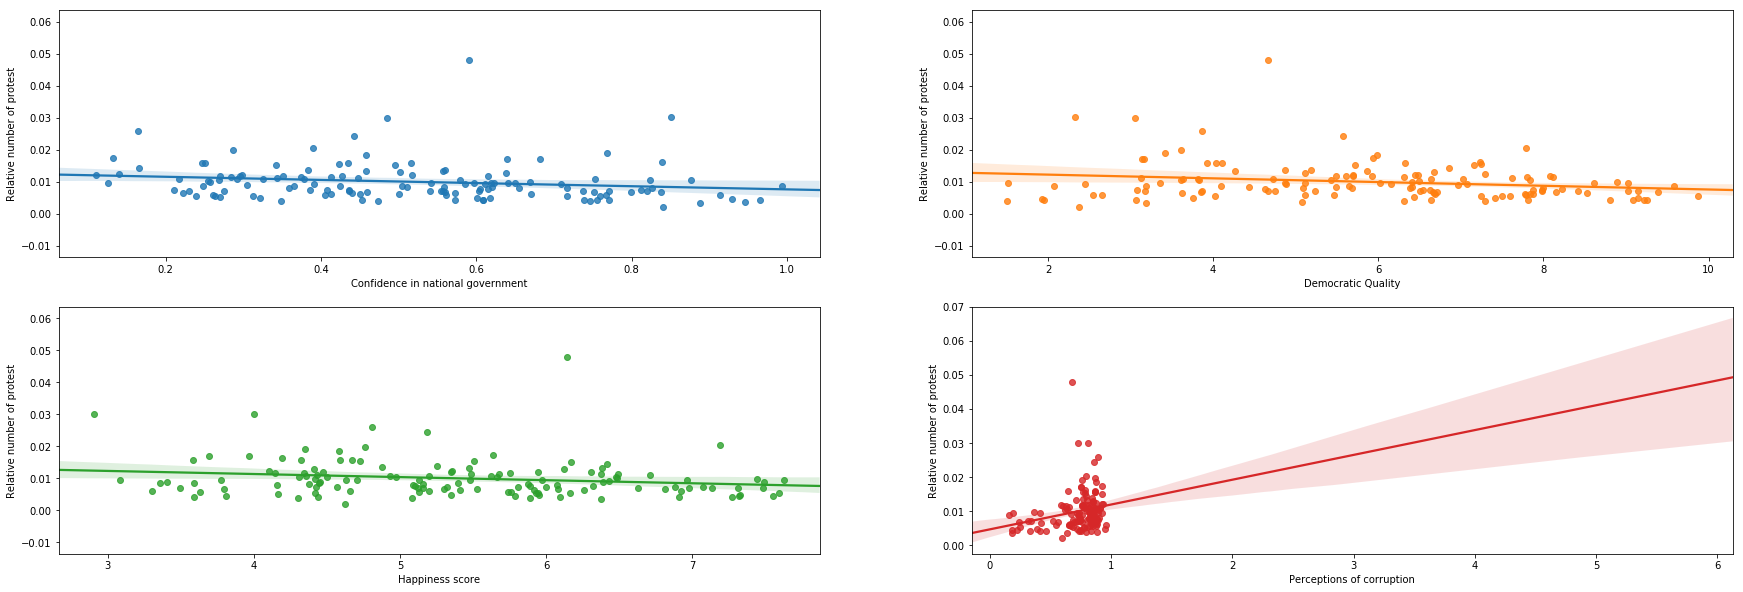

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(30, 10))

#axs[0][0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Confidence in national government', 'Relative number of protest', data=relative_mentions, ax=axs[0][0])

#axs[0][1].set_title('Relation between population and number of protests ')
_=sn.regplot('Democratic Quality', 'Relative number of protest', data=relative_mentions, ax=axs[0][1])

#axs[1][0].set_title("Relation between democratic quality and number of protests")
_=sn.regplot('Happiness score', 'Relative number of protest', data=relative_mentions, ax=axs[1][0])

#axs[1][1].set_title('Relation between population and number of protests ')
_=sn.regplot('Perceptions of corruption', 'Relative number of protest', data=relative_mentions, ax=axs[1][1])

For plotting the box plots for each relation, we bootstrapped and adopted the following methodology:

1.) We bootstrapped the pearson coefficient. To this end, we sampled 500 times the original data (each sample size is the length of the data). From each sample we calculated the pearson coefficient.

2.) We computed the mean of all the pearson coefficients calculated from each sample separetly.

3.) We converted the average pearson coefficient to Fisher's z' parameter with the following formula: 
$z'= \frac{log(\frac{1+r}{1-r})}{2}$

4.) $\textbf{CI}=[z'-t\cdot\sigma ; \ \ z'+t\cdot\sigma]$, where $t=1.96$ and $\sigma = \frac{1}{\sqrt{N-3}}$, where N is the sample size. $t=1.96$ given by the quantiles from the bootstrap distribution of the Student's t-test with 999 degrees of freedom for a 95% confidence interval.

5.) The final step is converting back the confidence interval limits to average pearson coefficient with the following formula:
$r = \frac{e^{2z'}-1}{e^{2z'}+1}$

In [15]:
def bootstrapping(data, number_of_sample, features, t=1.96):
    feature1 = features[0]
    feature2 = features[1]
    r = []
    sample_size = len(data)
    for i in range(number_of_sample):
        rnd_idx = np.random.randint(0, len(data), size=sample_size)
        data_sampled = data.iloc[rnd_idx]
        pearson_coeff = sp.stats.pearsonr(data_sampled[feature1], data_sampled[feature2])[0]
        # if the sample contains only identical values, the std is zero and pearsonr return NaN because of 
        # an impossible division by zero
        if not math.isnan(pearson_coeff):
            r.append(pearson_coeff)
     
    r_mean = np.mean(r) 
    z = np.log((1+r_mean)/(1-r_mean))/2
    std_err = 1/np.sqrt(sample_size-3)
    lower_z = z - std_err*t
    upper_z = z + std_err*t
    
    lower_r = (np.exp(2*lower_z)-1)/(np.exp(2*lower_z)+1)
    upper_r = (np.exp(2*upper_z)-1)/(np.exp(2*upper_z)+1)
    CI = (lower_r, upper_r)
    return r , CI

<Figure size 7200x7200 with 0 Axes>

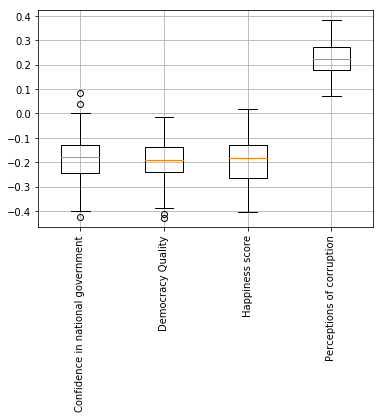

<Figure size 7200x7200 with 0 Axes>

In [16]:
number_of_sample = 200

confidence_in_gov_coefs, confidence_in_gov_coef_ci = bootstrapping(relative_mentions, \
                                                                   number_of_sample, \
                                                                   features=['Confidence in national government', \
                                                                             'Relative number of protest' \
                                                                            ] \
                                                                  )

democratic_quality_coefs, democratic_quality_coef_ci = bootstrapping(relative_mentions, \
                                                                     number_of_sample, \
                                                                     features=['Democratic Quality', \
                                                                               'Relative number of protest' \
                                                                              ] \
                                                                    )

happiness_coefs, happiness_coef_ci = bootstrapping(relative_mentions, \
                                                   number_of_sample, \
                                                   features=['Happiness score', \
                                                             'Relative number of protest' \
                                                            ] \
                                                  )

corruption_coefs, corruption_coef_ci = bootstrapping(relative_mentions, \
                                                     number_of_sample, \
                                                     features=['Perceptions of corruption', \
                                                               'Relative number of protest' \
                                                              ] \
                                                    )


_=plt.boxplot([confidence_in_gov_coefs, democratic_quality_coefs, happiness_coefs, corruption_coefs], \
              conf_intervals=[confidence_in_gov_coef_ci, democratic_quality_coef_ci, \
                              happiness_coef_ci, corruption_coef_ci \
                             ], \
               manage_xticks = True \
             )

x = [1, 2, 3, 4]
labels=["Confidence in national government", "Democracy Quality", "Happiness score", "Perceptions of corruption" ]
plt.xticks(x, labels, rotation='vertical')
plt.grid(True)
plt.figure(figsize=(100,100))


In [17]:
relative_mentions.shape

(135, 11)